<a href="https://colab.research.google.com/github/swayam-joshi/Projects/blob/main/VisionTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vision Transformers Implementation and Documentation**


In [ ]:
! pip install [https://github.com/pandas-profiling/pandas-profiling/archive/master.zip](https://github.com/pandas-profiling/pandas-profiling/archive/master.zip)


/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: ` pip install [https://github.com/pandas-profiling/pandas-profiling/archive/master.zip](https://github.com/pandas-profiling/pandas-profiling/archive/master.zip)'


**Importing necessary libraries:**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.profiler import profile, record_function, ProfilerActivity
from tqdm import tqdm, trange

**Setting the seed:**

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

**Patchify function:**

Storing dimension of Image (N,C,H,W) in n,c,w,h var
namely C=no.of channels, W=Width , H=Height

For this method Image needs to be a square H==W

we intializse a patch tensor with zeros with modified dimensions (N,PxP,HxC/P x WxC/P) i.e (N,Patches,Patch dimensionality)

Patch size we would take would be the number of patches divided by dimension H/P





In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

**MSA Block:**

Block diagram for MSA:



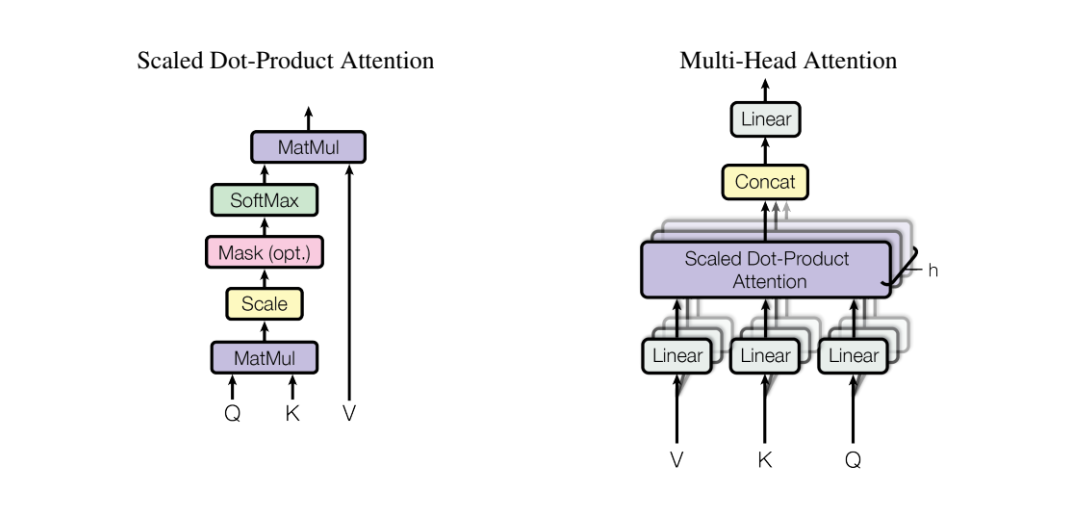

Explanation for MSA:

In self-attention, <mark>we create three vectors from the input vector of each image patch.</mark> These three vectors are labelled key, query, and value.

To calculate the self-attention, we need to calculate a certain "score" for each image patch with respect to other image patches. This enables an image patch to establish a certain amount of "relationship" with other image patches. To calculate the score, we take the dot product of the query of the image patch and the key of another(or the same) image patch. For example- if we are trying to process the self-attention of the first image patch, the first score would be the dot product of q1 and k1. The second score would be q1 and k2 and so on.

<mark>We then divide the scores by the square root of the dimension of the key vectors</mark> and pass it through a softmax function which normalises the scores so they are positive and add up to 1. This softmax score determines how much image patch will be expressed in this position.

Each value vector is then multiplied by the softmax score and then summed up. This is the final output of the self-attention block. We can calculate this output for each image patch.

Now, we can have multiple sets of query/key/values with different weight values established during the initialisation. Each set is called a "head". Since there are multiple heads, it is called "Multi-headed Self Attention".
Each of these heads focus on different positions, allowing for more accuracy at the expense of computational power.

However, the feed-forward layer is not expecting multiple matrices. <mark>Therefore, we need a final concatenation layer which multiplies the matrices with an additional weights matrix to finally get a single condensed matrix.</mark>

Implementation of MSA:

Our class MyMSA has a constructor with <mark>d=dimensions</mark> and n_heads=number of heads.

<mark>The documentation regarding nn.ModuleList is a bit confusing so I will have to go through the documentation of nn.Module itself to fully understand the implementation of MSA.</mark>


In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

**ViT Block:**


The constructor first takes input of the hidden_d(the output dimension sort of after the linear transformation of the patches),mthe number of heads(for the multi head self attention i think), and an optional mlp ratio which is set to 4 by default

4 layers for the vit bloack are defined :-



*   The first normalisation layer
*   Then a mhsa layer is defined using the MyMSA class
*   Then another normalisatio layer
*   Finally the MLP head- made up of 2 linear layers(dense layers) and the GELU activation function

Pictorial representation of the forward function-

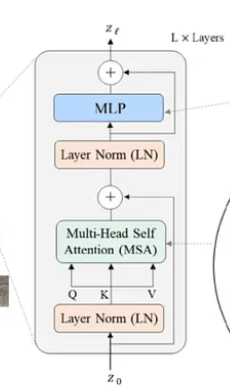







In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

**Positional Embedding:**

result tensor with torch.one will intialize a tensor with dimensions 50x8

Then iterating through the tensor with i begin the ith token total of 49 tokens and 8 co-ordinates in it
j is the jth co-ordinate

then using sine cosine similarity to do the positonal encoding as per this function bellow

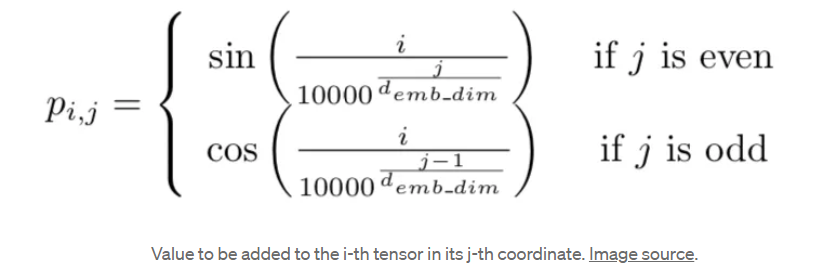

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

**Setting up ViT:**

MyVit class inherits from the Module class in nn(neural netwroks) package of pytorch-this helps us to use many funcionalities of pytorch for building neural netwroks

It first takes input of assign the chw values i.e. channels,height,width(in our case channel is one because monotone images)

Then the optional input of number of patches(per axis i think) which is set to 7 by default

Then n_blocks is i think is the number of MyVitBlock class blocks we use

hidden_d is the the dimension size after the first linear transformation and out_d is the final dimension(i.e the final classfication softmax will give probabilties between the 10 digits)

the assert lines make sure that the height and width are multiples of the number of patches per axis

then the linear mapper layer is defined as a nn.Linear layer which converts from the input dimension to the hidden dimension

Then a classification token[class_token] is initiated (as nn.Parameter) which will be vertically stacked onto the tokens after the first linear mapping.
"nn.Parameter": This is a special kind of Tensor in PyTorch that is a learnable parameter. It tells PyTorch to include this tensor as a parameter to be optimized during training.

Then the positional embedding values are added as buffers(not nn.Parametrer since tehse values are not to be changed while training the model)

the "n_blocks" number of blocks of MyVitBlocks are made is made [ye wal part thoda confusing hai, so help]

then the final mlp layer which is again a nn.Linear layer going from the hiiden_d to the final out_d and softmax activation function is added

The Forward funxtion then brings together and uses all the above defined layers

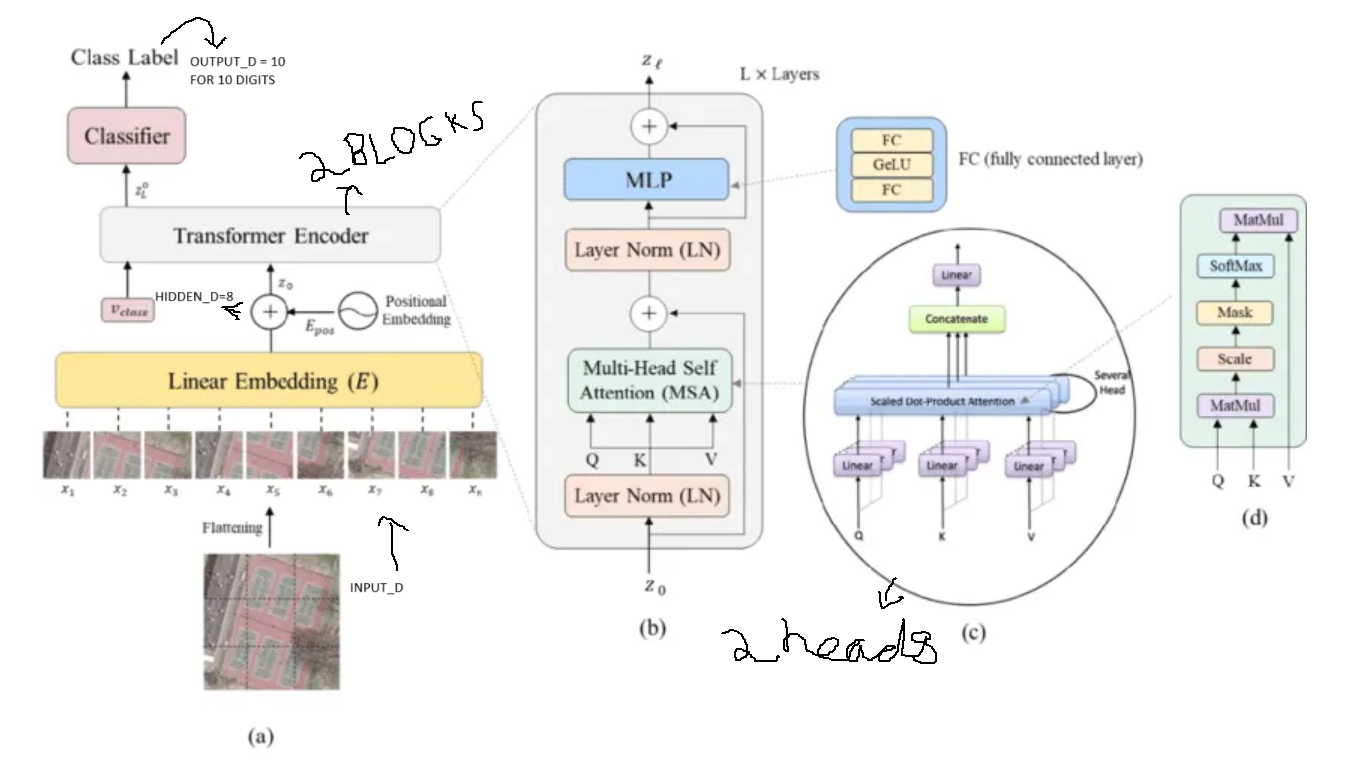


In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=1, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution


**Main Function:**

In [ ]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(
        root="./../datasets", train=True, download=True, transform=transform
    )
    test_set = MNIST(
        root="./../datasets", train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(
        "Using device: ",
        device,
        f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
    )
    model = MyViT(
        (1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10
    ).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1} in training", leave=False
        ):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            print(f"yhat shape {y_hat.shape}")
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


if __name__ == "__main__":
    main()

100%|██████████| 9912422/9912422 [00:00<00:00, 151074532.14it/s]

Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]

Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 47108409.60it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5256768.42it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw

Using device:  cuda (Tesla T4)


Training:  20%|██        | 1/5 [05:34<22:17, 334.27s/it]

Epoch 1/5 loss: 2.12



Training:  40%|████      | 2/5 [11:05<16:37, 332.58s/it]

Epoch 2/5 loss: 1.86



Training:  60%|██████    | 3/5 [16:39<11:05, 333.00s/it]

Epoch 3/5 loss: 1.76



Training:  80%|████████  | 4/5 [22:13<05:33, 333.65s/it]

Epoch 4/5 loss: 1.70



Training: 100%|██████████| 5/5 [27:48<00:00, 333.79s/it]


Epoch 5/5 loss: 1.68


Testing: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]

Test loss: 1.71
Test accuracy: 74.98%


In [ ]:
profile = ProfileReport(df, title='Heart Disease', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

NameError: name 'ProfileReport' is not defined

Code Reference: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c